# データ分析におけるデータの前処理とデータセット分割のポイント

参考
- 前処理 https://sebastianraschka.com/faq/docs/scale-training-test.html
- データセット https://machinelearningmastery.com/difference-test-validation-datasets/?utm_source=chatgpt.com

## 導入

機械学習やデータ分析を勉強していると、あとから振り返って「先にここを整理しておけば、遠回りしなかった」と感じるポイントがあります。

それが、前処理（preprocessing） と データセット分割（dataset split） です。

多くの場合、最初はモデルやアルゴリズムに目が行きます。
しかし実際には、標準化（scaling / standardization）や正規化（normalization）をどのデータで行うか、そして データセットを train / test の2つだけで考えてよいのか といった点も、結果の信頼性に直結します。

ここがあいまいなまま進めると、分類の精度（accuracy）やスコアが良く見えても、あとで「データの扱い方が不適切だった」と気づくことがあります。
製造業のデータ分析（異常検知、品質監視、センサーデータ解析、時系列データの判定）でも同じで、特に 異常検知のしきい値（threshold）をどのデータで決めるか は重要です。

自分もこの部分は、しっかり理解しないまま進めてしまい、勘違いしていたところがありました。

たとえば、最初はこう考えがちです。

「標準化は、train data と test data でそれぞれ平均・分散を出した方が自然では？」
「データセットは train / test の2つで十分では？」
「異常判定の threshold は、学習に使ったデータの分位点（percentile）で決めればよいのでは？」

どれも一見もっともらしく見えます。
ただ、ここには 情報漏れ（data leakage） や 性能の過大評価 につながる落とし穴があります。

この記事では、こうした勘違いしやすいポイントを、自分の頭の整理 を目的にまとめます。

この記事で整理したいポイントは、次の3つです。

1. 前処理（preprocessing）の基本ルール
標準化の平均・分散（または標準偏差）は、モデル学習用の train データだけ で計算する。

2. データセット分割（dataset split）の基本
データは train / test の2分割ではなく、
モデル学習用（train） / 校正・調整用（validation or calibration） / 最終評価用（test） の3つの役割で考える。

3. しきい値（threshold）設計の基本
異常検知の threshold は、学習に使ったデータではなく、validation / calibration 用のデータで決める。

この3つを先に整理しておくと、
「とりあえず動いた」から一歩進んで、現場で使える分析フローを組み立てやすくなります。

## 1. データセットは train / test の2つではなく、3つで分けるべき場合がある。

機械学習の入門では、まず train / test の2分割が出てきます。これは基本として正しいです。

ただし、実際の分析では、モデル学習だけでなく、特徴量の調整、ハイパーパラメータ調整、閾値（threshold）調整まで行います。このとき、test を調整に使ったり、学習に使った train データでしきい値を決めたりすると、見かけ上の性能は良くても、評価が過大になりやすく、最終評価として信頼しにくくなります。

Google の教材でも、開発中に test を使って調整を繰り返すと、モデルが test の癖に寄ってしまうため、train / validation / test の3分割を勧めています。

https://developers.google.com/machine-learning/crash-course/overfitting/dividing-datasets?hl=ja

MachineLearningMasteryの記事でも、validation は「調整中の見積もり」、test は「最終的な性能の見積もり」と役割を分けて説明されています。また、用語として validation と test が混同される文脈があることや、 validation の代わりに calibration（校正） という言い方をすることも多いです。異常検知では、この「調整」にあたる部分が特に重要なので気を付けてる必要があります。

https://machinelearningmastery.com/difference-test-validation-datasets/?utm_source=chatgpt.com

大事なのは、「学習」「調整」「最終評価」は役割が違う という点です。
この考え方をはっきりさせるために、データセットは次の3つの役割で分けて考えます。

モデル学習用（train）
モデルのパラメータを学習するためのデータ

校正・調整用（validation / calibration）
閾値（threshold）や各種設定を決めるためのデータ
（この記事では validation と calibration を同じ役割として扱います）

最終評価用（test）
最後に一度だけ性能を確認するためのデータ

悪い例と良い例の違いは次のようになります。

悪い例
学習に使ったデータで、そのまま閾値まで決めてしまう。
さらに test を見ながら調整を繰り返してしまう。
→ 見かけ上は性能が良く見えても、実運用では誤報や見逃しが増えやすい。

良い例
train でモデルを学習し、validation / calibration で閾値や設定を決める。
test は最後の1回だけ使う。
→ 評価結果が実運用に近くなり、信頼しやすい。

この違いを 最小のサンプルコード で確認します。
例として異常検知モデルを1つ使い、しきい値を train で決めた場合 と calibration で決めた場合 で、誤報率や検知率がどう変わるかを見ていきます。

=== threshold comparison ===
Bad  (trainで閾値):  thr = 0.7136
Good (calibで閾値):  thr = 0.6558

=== test result ===
Bad  : 誤報率FPR=0.000, 検知率TPR=0.233
Good : 誤報率FPR=0.020, 検知率TPR=0.747


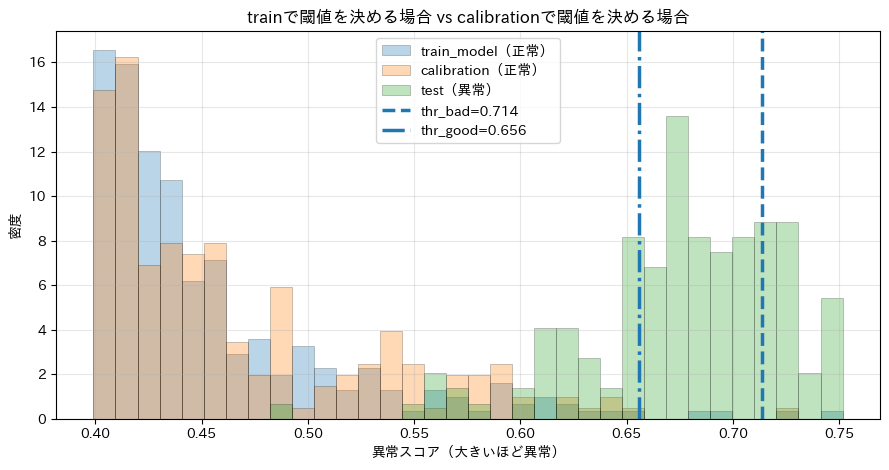

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語表示用（環境によっては不要）
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# ============================================================
# 0) ダミーデータ作成（2次元）
# ------------------------------------------------------------
# このサンプルでは、説明をわかりやすくするために
# 2つの特徴量を持つデータを人工的に作る。
#
# - 正常データ: 1つのまとまった分布
# - 異常データ: 正常分布から少し離れた分布
# ============================================================

# 乱数生成器（再現性を持たせるため seed を固定）
rng = np.random.default_rng(42)

# 正常データ（合計800点）
# mean=[0,0] を中心に、少し相関のある2次元データを生成
# cov の非対角成分 0.6 が「2特徴の相関」の強さ
X_normal = rng.multivariate_normal(
    mean=[0, 0],
    cov=[[1.0, 0.6], [0.6, 1.0]],
    size=800
)

# 異常データ（test用）
# 正常より中心位置をずらして生成（= 異常として区別しやすい）
X_anom = rng.multivariate_normal(
    mean=[2.5, -2.0],
    cov=[[1.0, 0.2], [0.2, 0.8]],
    size=150
)

# ============================================================
# 1) まず train / test に分ける
# ------------------------------------------------------------
# ここでは異常検知を想定して、
# - train 側には「正常のみ」を置く
# - test 側には「正常 + 異常」を混ぜる
# ============================================================

# 元の train（正常のみ）
X_train_all = X_normal[:500]
# test用の正常データ
X_test_normal = X_normal[500:700]
# test = 正常 + 異常 を結合
X_test = np.vstack([X_test_normal, X_anom])

# 正解ラベル（評価用）
# 0: 正常, 1: 異常
y_test = np.hstack([
    np.zeros(len(X_test_normal), dtype=int),
    np.ones(len(X_anom), dtype=int)
])

# ============================================================
# 2) train をさらに分ける（ここが重要）
# ------------------------------------------------------------
# 「元の train（正常のみ）」をさらに2つに分ける:
# - train_model : モデル学習用
# - calibration : 閾値（threshold）決定用
# ============================================================

X_train_model = X_train_all[:300]   # モデル学習用（正常）
X_calib = X_train_all[300:500]      # 閾値決定用（正常）

# ============================================================
# 3) 前処理（標準化）
# ------------------------------------------------------------
# StandardScaler は、各特徴量を
#   (値 - 平均) / 標準偏差
# の形でスケールする。
# ============================================================
scaler = StandardScaler()
X_train_model_s = scaler.fit_transform(X_train_model)
X_calib_s = scaler.transform(X_calib)
X_test_s = scaler.transform(X_test)

# ============================================================
# 4) 異常検知モデル（IsolationForest）
# ------------------------------------------------------------
# IsolationForest:
# データをランダムに分割していき、孤立しやすい点（=異常）を見つける手法
# ============================================================

model = IsolationForest(
    n_estimators=200,      # 木の本数（多いほど安定しやすい）
    contamination="auto",  # 内部の異常割合推定は使うが、閾値は自前で設定
    random_state=30        # 再現性のため固定
)
# モデル学習（正常データのみ）
model.fit(X_train_model_s)

# ============================================================
# 5) 異常スコアの計算
# ------------------------------------------------------------
# IsolationForest の score_samples は、
# 「大きいほど正常っぽい」スコア（=正常度）に近い値を返す。
#
# 今回は説明を統一するため、
# "大きいほど異常" になるように符号を反転して使う。
# ============================================================

# 学習用データのスコア（正常）
score_train = -model.score_samples(X_train_model_s)
# 閾値決定用データのスコア（正常）
score_calib = -model.score_samples(X_calib_s)
# test データのスコア（正常 + 異常）
score_test = -model.score_samples(X_test_s)

# ============================================================
# 6) 閾値の決め方を比較
# ------------------------------------------------------------
# 比較したい2つのケース:
#
# [悪い例]
#   train_model のスコア分布で閾値を決める
#   -> 学習データに合いすぎた分布を基準にしやすい
#
# [良い例]
#   calibration（学習に使っていない正常）のスコア分布で閾値を決める
#   -> 実運用に近い正常のばらつきを反映しやすい
# ============================================================

q = 0.995  # 99.5%分位点
# 悪い例: train_model で閾値
thr_bad = np.quantile(score_train, q)
# 良い例: calibration で閾値
thr_good = np.quantile(score_calib, q)
# 閾値よりスコアが大きければ「異常(1)」と判定
pred_bad = (score_test > thr_bad).astype(int)
pred_good = (score_test > thr_good).astype(int)

# ============================================================
# 7) 評価（誤報率 FPR / 検知率 TPR）
# ------------------------------------------------------------
# FPR（False Positive Rate）:
#   正常なのに異常と判定してしまう割合（誤報率）
#
# TPR（True Positive Rate）:
#   異常を正しく異常と判定できた割合（検知率）
# ============================================================

def calc_rates(y_true, y_pred):
    """誤報率(FPR)と検知率(TPR)を計算する簡単な関数"""
    normal = (y_true == 0)  # 正常データの位置
    anom = (y_true == 1)    # 異常データの位置
    fpr = (y_pred[normal] == 1).mean()   # 正常を異常と判定した割合
    tpr = (y_pred[anom] == 1).mean() # 異常を異常と判定できた割合
    return fpr, tpr

# 2つの閾値設定で比較
fpr_bad, tpr_bad = calc_rates(y_test, pred_bad)
fpr_good, tpr_good = calc_rates(y_test, pred_good)

# 結果表示
print("=== threshold comparison ===")
print(f"Bad  (trainで閾値):  thr = {thr_bad:.4f}")
print(f"Good (calibで閾値):  thr = {thr_good:.4f}")
print()
print("=== test result ===")
print(f"Bad  : 誤報率FPR={fpr_bad:.3f}, 検知率TPR={tpr_bad:.3f}")
print(f"Good : 誤報率FPR={fpr_good:.3f}, 検知率TPR={tpr_good:.3f}")

# ============================================================
# 8) スコア分布の可視化
# ------------------------------------------------------------
# 目的:
# - train / calibration / test異常 のスコア分布の違いを見る
# - 閾値線（thr_bad / thr_good）がどこにあるか確認する
# - 横軸は「異常スコア（大きいほど異常）」
# ============================================================

plt.figure(figsize=(9, 4.8))
# bins（ヒストグラムの区切り）を共通化して比較しやすくする
# 1%〜99%の範囲に絞ることで、極端な外れ値に引っ張られにくくする
all_scores = np.hstack([score_train, score_calib, score_test])
bins = np.linspace(
    np.quantile(all_scores, 0.01),
    np.quantile(all_scores, 0.99),
    35
)

# train_model（正常）の分布
# alpha を小さめにして重なっても見やすくする
plt.hist(
    score_train,
    bins=bins,
    density=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
    label="train_model（正常）"
)

# calibration（正常）の分布
plt.hist(
    score_calib,
    bins=bins,
    density=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
    label="calibration（正常）"
)

# test の異常データの分布
plt.hist(
    score_test[y_test == 1],
    bins=bins,
    density=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
    label="test（異常）"
)

# 閾値線（比較しやすいように太め）
plt.axvline(thr_bad, linestyle="--", linewidth=2.5, label=f"thr_bad={thr_bad:.3f}")
plt.axvline(thr_good, linestyle="-.", linewidth=2.5, label=f"thr_good={thr_good:.3f}")

# 軸・タイトル・凡例
plt.xlabel("異常スコア（大きいほど異常）")
plt.ylabel("密度")
plt.title("trainで閾値を決める場合 vs calibrationで閾値を決める場合")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

今回の結果では、学習に使った train のスコア分布だけで閾値を決めると、モデルが train に合いすぎた状態（過学習ぎみ） の影響で、閾値が高めになりました。
その結果、train 上ではきれいに見えても、学習に使っていないデータでは異常を見逃しやすくなります。
実際に今回も、train で決めた閾値では誤報率（FPR）は 0.000 でしたが、検知率（TPR）は 0.233 と低く、異常の見逃しが多い結果になりました。
一方、calibration（学習に使っていない正常データ）で閾値を決めると、実運用に近いばらつきを反映でき、検知率は 0.747 まで改善しました。
この例から、異常検知では train / calibration / test の3つの役割でデータを分けることが重要だと分かります。

## 2. 標準化・正規化の落とし穴：fit するデータを間違えると評価が崩れる

前述のコードで、下のような前処理を書いていました。

In [ ]:
scaler = StandardScaler()
X_train_model_s = scaler.fit_transform(X_train_model)
X_calib_s       = scaler.transform(X_calib)
X_test_s        = scaler.transform(X_test)

ここ、何をしているか本当に説明できますか？
それとも、StandardScaler はよく見るから、とりあえず書いて流していませんでしたか？

この部分は、単なるお作法ではありません。
ここを曖昧にしたまま進むと、せっかく train / calibration / test に分けても、前処理の段階で情報漏れ（data leakage） を起こします。

しかもこの話は、標準化（standardization）だけの話ではありません。
正規化（normalization）や min-max 変換など、「データから基準値を計算して変換する前処理」全般 にそのまま当てはまります。
scikit-learn の公式などの記事でも、これを典型的な落とし穴としてまとめられています

https://sebastianraschka.com/faq/docs/scale-training-test.html

以降は、下の記事の内容を参考に、標準化の例で確認していきます

https://scikit-learn.org/stable/common_pitfalls.html

まずは標準化の関数の確認です。

fit は、前処理に必要な基準値を学ぶ処理です。
標準化なら、平均と標準偏差を計算します。
正規化（Min-Max など）なら、最小値と最大値を計算します。

transform は、すでに学んだ基準値を使って、データを変換する処理です。

fit_transform は、その2つをまとめて実行するだけです。

例A：train / calib / test をそれぞれ別々に標準化する

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
X_train_s = scaler_train.fit_transform(X_train)

scaler_calib = StandardScaler()
X_calib_s = scaler_calib.fit_transform(X_calib)  # ← calibでもfitしている（NG）

scaler_test = StandardScaler()
X_test_s = scaler_test.fit_transform(X_test)     # ← testでもfitしている（NG）

一見、自然に見える書き方です。
でもこれは、train と test で別の基準（平均・標準偏差） を使っている状態です。

モデルは train を変換した座標で学習しているのに、test は別の座標に変換されます。
これでは、学習時と評価時で前提がズレます。

train / calib / test をまとめて標準化する

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# すでに分かれているデータを、前処理のためにまとめてしまう（NG）
X_all = np.vstack([X_train, X_calib, X_test])

scaler = StandardScaler()
scaler.fit(X_all)  # ← calib/test の情報まで使って基準を作っている（NG）

X_train_s = scaler.transform(X_train)
X_calib_s = scaler.transform(X_calib)
X_test_s  = scaler.transform(X_test)

これは同じ物差しを使っているので、シナリオ1より正しそうに見えます。
ただし、calib と test の情報を前処理の基準に混ぜているので、情報漏れです。

train で基準を作り、calib / test は同じ基準で変換する

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fitはtrainだけ
X_train_s = scaler.fit_transform(X_train)

# calib / test は、trainで作った基準で変換するだけ
X_calib_s = scaler.transform(X_calib)
X_test_s  = scaler.transform(X_test)

これが正しい形です。
fit に相当する処理（平均・標準偏差の計算）は train だけで行い、calib と test はその基準を使って変換します。

この3つを見比べると、前処理のルールは1行で言えます。

fit は train だけ、calibration と test は transform だけ。

このルールは StandardScaler だけでなく、MinMaxScaler などの正規化でも同じです。